# 🧠 Tensor Indexing & Axis Reminder

## 🔹 Core Rule

For a tensor of shape:

(d0, d1, d2, ..., dn)

Indexing always follows:

tensor[i0, i1, i2, ..., in]

Each comma corresponds to one axis.

---

## 🔹 The Golden Rules

1. `:` → keeps the entire axis  
2. A number (e.g., `2`) → selects one index and **removes that axis**  
3. A slice (e.g., `2:4`) → keeps that axis but reduces its size  

---

## 🔹 2D Example

If:

X.shape = (3, 2)

X =  
[[1, 2],  
 [3, 4],  
 [5, 6]]

- `X[:, 0]` → shape (3,)  
  → selects first column (axis 1 removed)

- `X[0, :]` → shape (2,)  
  → selects first row (axis 0 removed)

---

## 🔹 3D Example

If:

X.shape = (4, 3, 2)

Meaning:
- 4 blocks
- 3 rows per block
- 2 columns per row

- `X[:, 1, :]` → shape (4, 2)  
  → selects row index 1 from every block  
  → axis 1 removed

- `X[:, 1:2, :]` → shape (4, 1, 2)  
  → slice keeps axis 1 (size 1)

---

## 🔹 4D Example (Deep Learning Style)

T.shape = (2, 5, 4, 3)

- `T[:, 2, :, 1]` → shape (2, 4)  
  → axis 1 and axis 3 removed

- `T[:, 2:4, :, 1]` → shape (2, 2, 4)  
  → axis 1 kept (size 2 because slice)  
  → axis 3 removed

---


In [45]:
# Lets import a dataset, this one returns a set of points that form a circle
from sklearn.datasets import make_circles

n_samples=1000 # how many points we want
A, b= make_circles(n_samples, noise=0.1, random_state=42) # noise is the amount by which the points deviate from a perfect circle

In [46]:
A.shape, b.shape

((1000, 2), (1000,))

In [47]:
import pandas as pd
circles= pd.DataFrame({"x": A[:,0], "y": A[:,1], "label":b})
circles.head(10)

,x,y,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1
6,-0.022038,0.811310,1
7,0.729897,0.188943,1
8,-0.191616,-0.815790,1
9,-0.083442,1.093954,0


In [48]:
circles.label.value_counts()

,count
label,
1,500
0,500


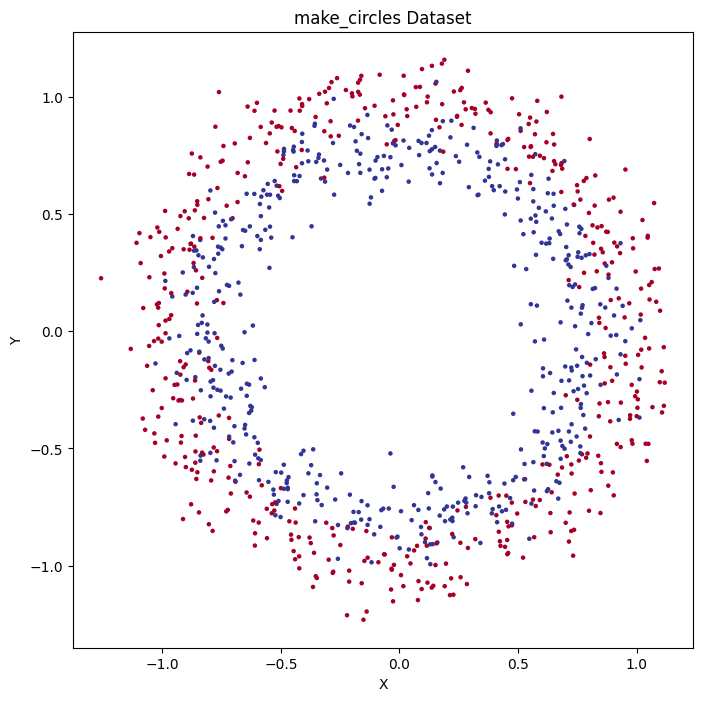

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

# color by label `b`
plt.scatter(
    x=A[:,0],
    y=A[:,1],
    c=b,                 
    cmap=plt.cm.RdYlBu,   
    s=5                   
)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('make_circles Dataset')
plt.show()


In [50]:
import torch
# First lets convert them to tensors
coordinates= torch.from_numpy(A).type(dtype=torch.float32)
labelValues= torch.from_numpy(b).type(dtype=torch.float32)

# Now lets split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(coordinates, labelValues, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([700, 2]),
 torch.Size([300, 2]),
 torch.Size([700]),
 torch.Size([300]))

In [51]:
from torch import nn

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2, out_features=5)
        self.layer2= nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))

model_circle_0= CircleModel()
with torch.inference_mode():
    y_pred= model_circle_0(X_train)

print(y_pred[:10])
print(y_test[:10])


tensor([[0.1747],
        [0.3116],
        [0.2956],
        [0.1816],
        [0.1354],
        [0.4043],
        [0.2274],
        [0.4539],
        [0.2897],
        [0.0179]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [52]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score

lossFn= torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD( params=model_circle_0.parameters(), lr=0.01)
epochs= 1000
for epoch in range(epochs):
    model_circle_0.train()
    y_logits_train= model_circle_0(X_train).squeeze()
    y_pred_train= torch.round(torch.sigmoid(y_logits_train))
    
    loss= lossFn(y_logits_train, y_train)
    acc= accuracy_score(y_train.detach().numpy(),y_pred_train.detach().numpy())
    prec= precision_score(y_train.detach().numpy(), y_pred_train.detach().numpy())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_circle_0.eval()
    with torch.inference_mode():
        y_logits_test= model_circle_0(X_test).squeeze()
        y_pred_test= torch.round(torch.sigmoid(y_logits_test))
        test_loss= lossFn(y_logits_test, y_test)
        test_acc= accuracy_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
        test_prec= precision_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
        
        if epoch % 50 == 0:
            print(f"Training accuracy: {acc} -------------- Training precision: {prec}")
            print(f"Test accuracy: {test_acc} ------------- Test precision: {test_prec}")

Training accuracy: 0.5514285714285714 -------------- Training precision: 0.5316265060240963
Test accuracy: 0.5066666666666667 ------------- Test precision: 0.49310344827586206
Training accuracy: 0.5728571428571428 -------------- Training precision: 0.5454545454545454
Test accuracy: 0.5366666666666666 ------------- Test precision: 0.509090909090909
Training accuracy: 0.5628571428571428 -------------- Training precision: 0.5426621160409556
Test accuracy: 0.53 ------------- Test precision: 0.5060728744939271
Training accuracy: 0.5485714285714286 -------------- Training precision: 0.5369003690036901
Test accuracy: 0.51 ------------- Test precision: 0.4935064935064935
Training accuracy: 0.54 -------------- Training precision: 0.533203125
Test accuracy: 0.49 ------------- Test precision: 0.4792626728110599
Training accuracy: 0.54 -------------- Training precision: 0.5345528455284553
Test accuracy: 0.5 ------------- Test precision: 0.4854368932038835
Training accuracy: 0.5442857142857143 ----

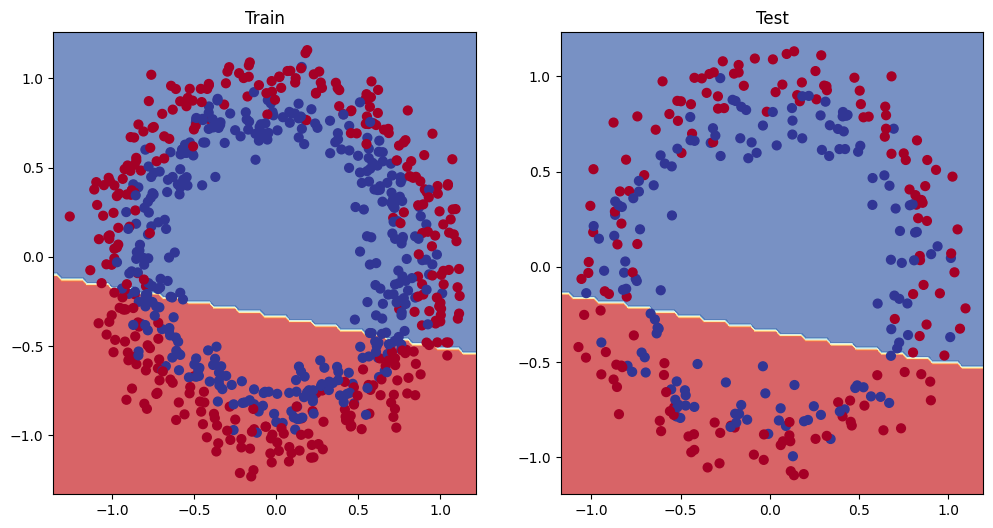

In [53]:
#ok from the result above we can see the model is not learning or  training well
# Why? because we are using only linear layers and the data we have is not linearly separable
# lets see what this means
import numpy as np

def plot_prediction(train_data, train_label, test_data, test_label, prediction=None):
    plt.figure(figsize=(7,3))
    plt.scatter(train_data, train_label, c='g', s=3, label='Training data' ) # c is for color, s is for size of the dots
    plt.scatter(test_data, test_label, c='b', s=3 , label='Test data')
    
    if prediction is not None: 
        plt.scatter(test_data, prediction, c='r', s=3, label='Prediction' )
    
    plt.legend(prop={'size':14})
    
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_circle_0 , X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_circle_0, X_test, y_test)


So the above model is clearly not performing well
what is missing? the missing piece is adding non linearity to our model. As seen above a simple line can not acurately separate the two classes

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([700, 2]),
 torch.Size([300, 2]),
 torch.Size([700]),
 torch.Size([300]))

In [55]:
class CircleModelImproved(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2 , out_features=8)
        self.layer2= nn.Linear(in_features=8, out_features=4)
        self.layer3= nn.Linear(in_features=4, out_features=1)
        self.relu= nn.ReLU()
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        rslt= self.layer1(x)
        rslt= self.relu(rslt)
        rslt= self.layer2(rslt)
        rslt= self.relu(rslt)
        rslt= self.layer3(rslt)
        return rslt
    
model_circle_1= CircleModelImproved()
lossFn= torch.nn.BCEWithLogitsLoss()
optmzr= torch.optim.Adam(params= model_circle_1.parameters(), lr=0.01)
epochs=5000
for epoch in range(epochs):
    model_circle_1.train()
    yy_logit_train= model_circle_1(X_train).squeeze()
    yy_pred_train= torch.round(torch.sigmoid(yy_logit_train))
    accr= accuracy_score(y_train.detach().numpy(), yy_pred_train.detach().numpy())
    loss_1_train= lossFn(yy_logit_train, y_train)
    
    optmzr.zero_grad()
    
    loss_1_train.backward()
    
    optmzr.step()
    model_circle_1.eval()
    with torch.inference_mode():
        yy_logit_test= model_circle_1(X_test).squeeze()
        yy_pred_test= torch.round(torch.sigmoid(yy_logit_test))
        accr_test= accuracy_score(y_test.detach().numpy(), yy_pred_test.detach().numpy())
        
        loss_1_test= lossFn(yy_logit_test, y_test)
        
        if epoch % 500 == 0:
            print(f"Train loss: {loss_1_train} ---------- Test loss: {loss_1_test}")
            print(f"Train accuracy: {accr} ---------- Test accuracy: {accr_test}")

print(yy_logit_train.shape)
print(y_train.shape)
print(y_train.dtype)

    


Train loss: 0.702278733253479 ---------- Test loss: 0.6939069628715515
Train accuracy: 0.49142857142857144 ---------- Test accuracy: 0.52
Train loss: 0.3221461772918701 ---------- Test loss: 0.517997145652771
Train accuracy: 0.8614285714285714 ---------- Test accuracy: 0.77
Train loss: 0.32215991616249084 ---------- Test loss: 0.517389178276062
Train accuracy: 0.8628571428571429 ---------- Test accuracy: 0.7733333333333333
Train loss: 0.322151780128479 ---------- Test loss: 0.518913745880127
Train accuracy: 0.8628571428571429 ---------- Test accuracy: 0.7666666666666667
Train loss: 0.32212501764297485 ---------- Test loss: 0.5175752639770508
Train accuracy: 0.8657142857142858 ---------- Test accuracy: 0.7733333333333333
Train loss: 0.3221461772918701 ---------- Test loss: 0.5172879695892334
Train accuracy: 0.8628571428571429 ---------- Test accuracy: 0.7733333333333333
Train loss: 0.32212918996810913 ---------- Test loss: 0.518657922744751
Train accuracy: 0.8642857142857143 ---------- 

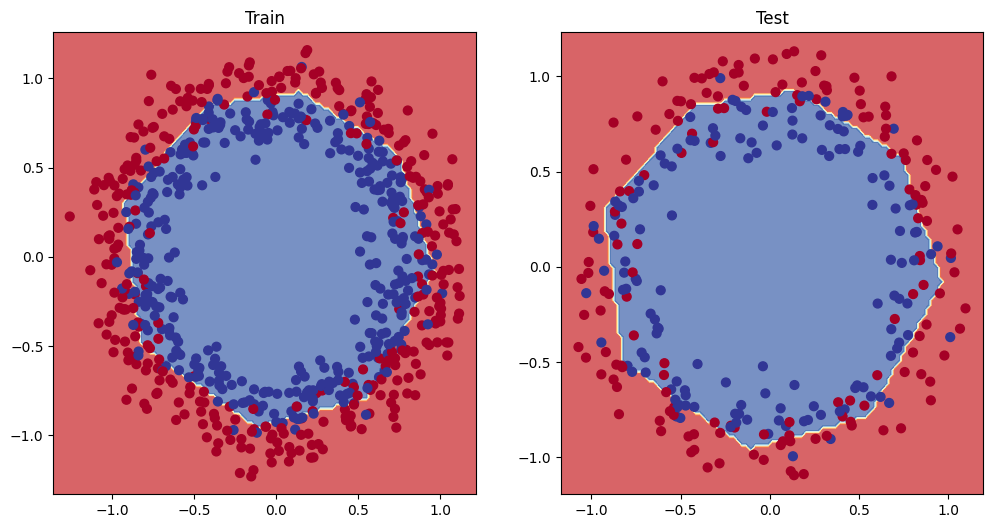

In [56]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_circle_1 , X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_circle_1, X_test, y_test)

Now on to Multi-class classification

In [58]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split



NUM_OF_FEATURES= 2
NUM_OF_CLASSES= 4
RANDOM_STATE= 42
X_blob, Y_blob= make_blobs(n_features= NUM_OF_FEATURES, n_samples=2000, centers= NUM_OF_CLASSES, random_state= RANDOM_STATE, cluster_std=1.8)
X_blob_tensor= torch.from_numpy(X_blob).type(torch.float32)
Y_blob_tensor= torch.from_numpy(Y_blob).type(torch.float32)


x_blob_train, x_blob_test, y_blob_train, y_blob_test= train_test_split(X_blob_tensor, Y_blob_tensor)
x_blob_train.shape, y_blob_train.shape, x_blob_test.shape, y_blob_test.shape

(torch.Size([1500, 2]),
 torch.Size([1500]),
 torch.Size([500, 2]),
 torch.Size([500]))

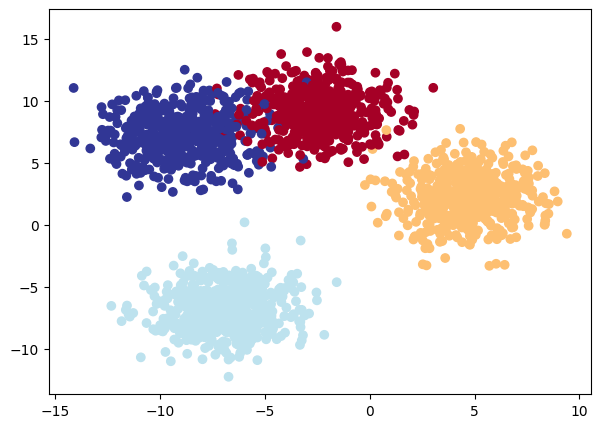

In [59]:
plt.figure(figsize=(7, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, cmap=plt.cm.RdYlBu);

In [68]:
import pandas as pd

data= pd.DataFrame({"x1":X_blob_tensor[:, 0], "x2":X_blob_tensor[:, 1] , "Y": Y_blob_tensor})
data.head(10)

,x1,x2,Y
0,4.408511,-1.414159,1.0
1,5.614512,3.339649,1.0
2,-9.311561,-9.260534,2.0
3,-8.935356,5.555377,3.0
4,-5.253532,5.825812,3.0
5,-4.835511,-8.871438,2.0
6,-9.342594,-3.303013,2.0
7,3.786968,1.947156,1.0
8,-4.001389,8.005960,0.0
9,-4.756122,-6.530716,2.0


In [61]:
from torch import nn
class MultiClassClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2, out_features=8)
        self.layer2= nn.Linear( in_features=8, out_features=16)
        self.layer3= nn.Linear(in_features=16, out_features=8)
        self.layer4= nn.Linear(in_features=8, out_features=4)
        self.relu= nn.ReLU()
        
    def forward(self, x:torch.Tensor)-> torch.Tensor:
        res= self.layer1(x)
        res= self.relu(res)
        res= self.layer2(res)
        res= self.relu(res)
        res= self.layer3(res)
        res= self.relu(res)
        res= self.layer4(res)
        return res
    

In [65]:
from sklearn.metrics import accuracy_score, precision_score

model_blob_0= MultiClassClassification()
lossFn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam( params= model_blob_0.parameters() ,lr= 0.01)

accr_scr_values= []
prec_scr_values= []
epoch_values= []
epochs=5000
for epoch in range(epochs):
    model_blob_0.train()
    
    y_blob_logits_train= model_blob_0(x_blob_train)
    y_blob_pred_train= torch.argmax(y_blob_logits_train, dim=1)

    
    blob_loss_train= lossFn(y_blob_logits_train, y_blob_train.long())
    
    optimizer.zero_grad()
    
    blob_loss_train.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0:
        model_blob_0.eval()
        print(blob_loss_train)
        with torch.inference_mode():
            logits = model_blob_0(x_blob_test)
            preds = torch.argmax(logits, dim=1)

            accur = accuracy_score(
                y_blob_test.numpy(),
                preds.numpy()
            )

            preci = precision_score(
                y_blob_test.numpy(),
                preds.numpy(),
                average='macro',
                zero_division=0
            )

            accr_scr_values.append(accur)
            prec_scr_values.append(preci)
            epoch_values.append(epoch)


tensor(1.4605, grad_fn=<NllLossBackward0>)
tensor(0.0597, grad_fn=<NllLossBackward0>)
tensor(0.0557, grad_fn=<NllLossBackward0>)
tensor(0.0540, grad_fn=<NllLossBackward0>)
tensor(0.0522, grad_fn=<NllLossBackward0>)
tensor(0.0517, grad_fn=<NllLossBackward0>)
tensor(0.0514, grad_fn=<NllLossBackward0>)
tensor(0.0509, grad_fn=<NllLossBackward0>)
tensor(0.0501, grad_fn=<NllLossBackward0>)
tensor(0.0500, grad_fn=<NllLossBackward0>)
tensor(0.0528, grad_fn=<NllLossBackward0>)
tensor(0.0485, grad_fn=<NllLossBackward0>)
tensor(0.0490, grad_fn=<NllLossBackward0>)
tensor(0.0477, grad_fn=<NllLossBackward0>)
tensor(0.0474, grad_fn=<NllLossBackward0>)
tensor(0.0471, grad_fn=<NllLossBackward0>)
tensor(0.0467, grad_fn=<NllLossBackward0>)
tensor(0.0469, grad_fn=<NllLossBackward0>)
tensor(0.0463, grad_fn=<NllLossBackward0>)
tensor(0.0464, grad_fn=<NllLossBackward0>)
tensor(0.0455, grad_fn=<NllLossBackward0>)
tensor(0.0463, grad_fn=<NllLossBackward0>)
tensor(0.0456, grad_fn=<NllLossBackward0>)
tensor(0.04

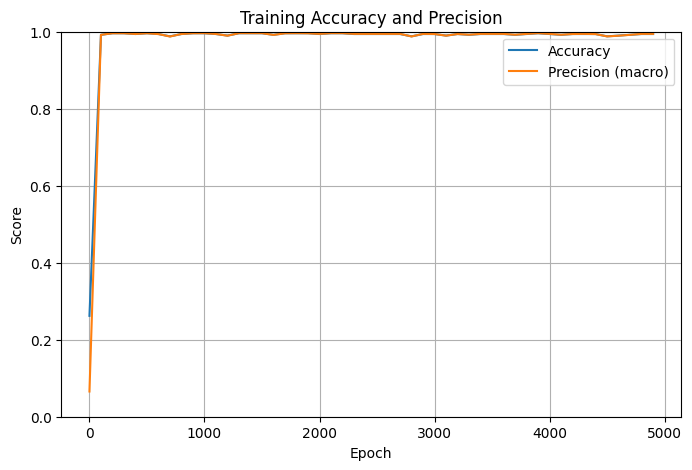

In [66]:
plt.figure(figsize=(8,5))

plt.plot(epoch_values, accr_scr_values, label="Accuracy")
plt.plot(epoch_values, prec_scr_values, label="Precision (macro)")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Accuracy and Precision")
plt.legend()
plt.grid(True)

plt.ylim(0, 1)  # since metrics are between 0 and 1

plt.show()

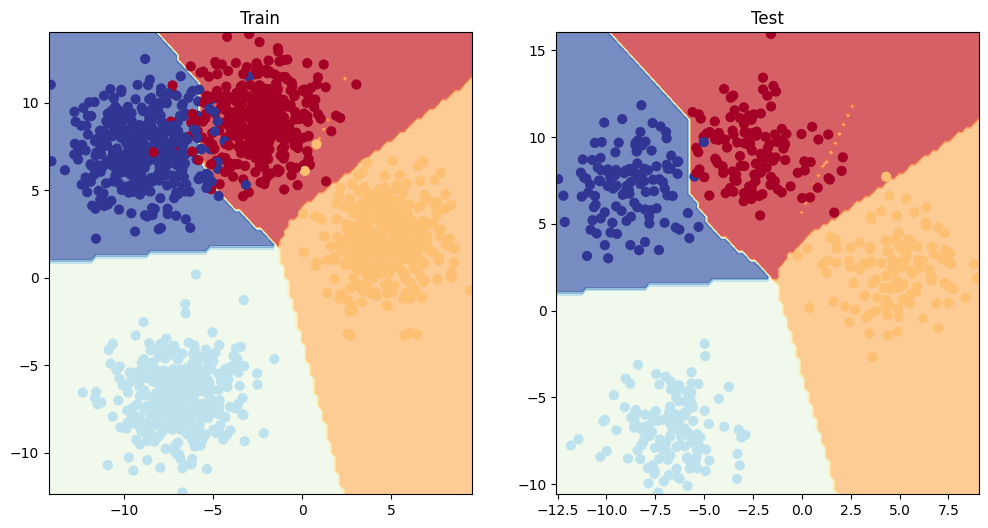

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob_0, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob_0, x_blob_test, y_blob_test)